# Trabajo Práctico N.° 3

## Imports y configs

In [91]:
# un poco menos de warnings de tensorflow
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# de python, para especificar rutas de archivos y directorios
from pathlib import Path

# lib para trabajar con arrays
import numpy as np
import pandas as pd
import seaborn as sns

# lib que usamos para mostrar las imágenes
import matplotlib.pyplot as plt

# libs que usamos para construir y entrenar redes neuronales, y que además tiene utilidades para leer sets de 
# imágenes
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Convolution2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications import VGG16
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten

# libs que usamos para tareas generales de machine learning. En este caso, métricas
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score

# configuración para que las imágenes se vean dentro del notebook
%matplotlib inline

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Análisis exploratorio sobre el conjunto de datos

Para que esto funcione, se debe bajar y descomprimir el archivo del siguiente [enlace](https://www.kaggle.com/jessicali9530/celeba-dataset). El mismo contiene:
* **img_align_celeba**: imágenes de rostros, recortadas y alineadas.
* **list_eval_partition.csv**: partición recomendada para las imagenes. Relaciona cada imagen con el atributo *partition*:
    * "0" si pertenece al conjunto de entrenamiento.
    * "1" si pertenece al conjunto de validación.
    * "2" si pertenece al conjunto de prueba.
* **list_bbox_celeba.csv**: información del cuadro delimitador para cada imagen.
* **list_landmarks_align_celeba.csv**: puntos de referencia (ojo izquierdo, ojo derecho, nariz, boca izquierda, boca derecha) y sus respectivas coordenadas.
* **list_attr_celeba.csv**: etiquetas (40 en total) de atributos para cada imagen. "1" representa positivo mientras que "-1" representa negativo.

En nuestro caso, utilizaremos las imágenes, *list_eval_partition.csv* y *list_attr_celeba.csv* para desarrollar un modelo que sea capaz de detectar si una persona tiene o no barba a partir de una foto. Entonces, nuestro target será el atributo *No_Beard*, que determina si una persona en una imagen no tiene barba.

In [92]:
# Modificar por la ruta donde se encuentran los archivos
current_path = 'C:/Users/matia/OneDrive/Documentos/archive/'
#current_path = '/home/yair/Files/archive/'

imgs_path = Path(current_path, 'img_align_celeba/img_align_celeba')
attr_path = Path(current_path, 'list_attr_celeba.csv')
partitions_path = Path(current_path, 'list_eval_partition.csv')

# Importamos y unimos los datasets de atributos y particiones
df_attr = pd.read_csv(attr_path, usecols=['image_id','No_Beard'])
df_partitions = pd.read_csv(partitions_path)
df = df_attr.merge(df_partitions, on="image_id", how="left")

df.sample(5)

,image_id,No_Beard,partition
17225,017226.jpg,1,0
145513,145514.jpg,1,0
105106,105107.jpg,1,0
194345,194346.jpg,1,2
21493,021494.jpg,1,0


In [93]:
class_names = ["Barba","No_barba"]

# Restablecemos los valores de la columna No_Beard
df.loc[df['No_Beard'] == -1,'No_Beard'] = "Barba"
df.loc[df['No_Beard'] == 1,'No_Beard'] = "No_Barba"

# Dividimos el dataframe en función de la columna partition
train = df.loc[df['partition'] == 0]
validation = df.loc[df['partition'] == 1]
test = df.loc[df['partition'] == 2]

# Eliminamos la columna partition de los 3 conjuntos
train = train.drop(['partition'],axis=1)
validation = validation.drop(['partition'],axis=1)
test = test.drop(['partition'],axis=1)

train.head(20)

,image_id,No_Beard
0,000001.jpg,No_Barba
1,000002.jpg,No_Barba
2,000003.jpg,No_Barba
3,000004.jpg,No_Barba
4,000005.jpg,No_Barba
5,000006.jpg,No_Barba
6,000007.jpg,No_Barba
7,000008.jpg,No_Barba
8,000009.jpg,No_Barba
9,000010.jpg,No_Barba


In [71]:
print("Cantidad total de imágenes:", len(df.image_id))
print("Cantidad de imágenes en train:", len(train.image_id))
print("Cantidad de imágenes en validation:", len(validation.image_id))
print("Cantidad de imágenes en test:", len(test.image_id))

Cantidad total de imágenes: 202599
Cantidad de imágenes en train: 162770
Cantidad de imágenes en validation: 19867
Cantidad de imágenes en test: 19962


## Volumetría de los datos

In [5]:
from PIL import Image

img_path = Path(str(imgs_path) + '/000002.jpg') # Este solo es un ejemplo
img = Image.open(img_path)

width, height = img.size
img_array = np.array(img)
depth = img_array.shape[2]

print(f'Alto de la imagen: {height} píxeles')
print(f'Ancho de la imagen: {width} píxeles')
print(f'Profundidad de la imagen (RGB): {depth}')

Alto de la imagen: 218 píxeles
Ancho de la imagen: 178 píxeles
Profundidad de la imagen (RGB): 3


## Distribución de la variable a predecir

In [6]:
category_count = df["No_Beard"].value_counts()
print(f'Cantidad total de imágenes de personas sin barba: {category_count.values[0]}')
print(f'Cantidad total de imágenes de personas con barba: {category_count.values[1]}')

Cantidad total de imágenes de personas sin barba: 169158
Cantidad total de imágenes de personas con barba: 33441


Text(0.5, 1.0, 'Test')

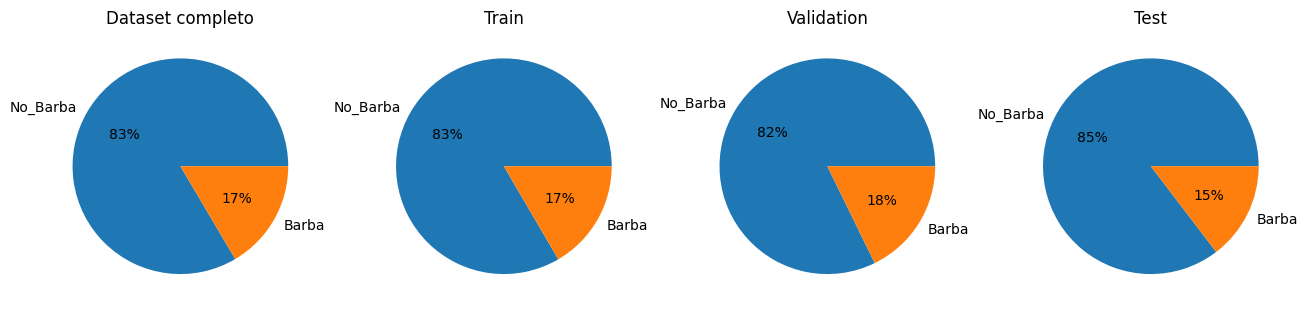

In [7]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16, 16))

df.No_Beard.value_counts().plot.pie(autopct='%1.0f%%', label='', ax=axs[0])
axs[0].set_title('Dataset completo')

train.No_Beard.value_counts().plot.pie(autopct='%1.0f%%', label='', ax=axs[1])
axs[1].set_title('Train')

validation.No_Beard.value_counts().plot.pie(autopct='%1.0f%%', label='', ax=axs[2])
axs[2].set_title('Validation')

test.No_Beard.value_counts().plot.pie(autopct='%1.0f%%', label='', ax=axs[3])
axs[3].set_title('Test')

Podemos concluir entonces que la métrica F1 es la que mejor se ajusta al problema ya que se tiene un conjunto de datos que se encuentra desbalanceado. Esto nos permite ponderar el rendimiento del modelo con respecto a los falsos positivos y falsos negativos.

## Estructura y tipo de las imágenes

Por cuestiones de tiempo de entrenamiento, vamos a aplicar cambios a las imágenes al armar los conjuntos de entrenamiento. Se va a reducir la dimensionalidad (alto y ancho), pasando de 218 x 178 píxeles a 64 x 64 píxeles. Por otra parte, optamos por normalizar los datos, rescalando los mismos para obtener un mejor desempeño al momento de ejecutar.

In [94]:
# Rescalaremos los valores de las imágenes
datagen = ImageDataGenerator(
    rescale=1./255,
)
# Para crear datasets de imágenes para Keras
IMAGE_SIZE = (64, 64)
BATCH_SIZE = 100
parameters = dict(
    x_col='image_id',
    y_col='No_Beard',
    target_size=(IMAGE_SIZE),
    class_mode='binary',
)

# Generar datasets
train_generator = datagen.flow_from_dataframe(train, str(imgs_path) + "/",**parameters)
validation_generator = datagen.flow_from_dataframe(validation,str(imgs_path) + "/",**parameters)
test_generator = datagen.flow_from_dataframe(test, str(imgs_path) + "/",**parameters)

Found 162770 validated image filenames belonging to 2 classes.
Found 19867 validated image filenames belonging to 2 classes.
Found 19962 validated image filenames belonging to 2 classes.


In [9]:
# Obtener un bloque (imagenes y etiquetas)
train_imgs, train_labels = train_generator.next()

In [10]:
# Estructura de una imagen
train_imgs[0]

array([[[0.5019608 , 0.38431376, 0.23529413],
        [0.49411768, 0.37647063, 0.23529413],
        [0.4784314 , 0.36862746, 0.22352943],
        ...,
        [0.42352945, 0.35686275, 0.25490198],
        [0.42352945, 0.35686275, 0.25490198],
        [0.42352945, 0.35686275, 0.2392157 ]],

       [[0.5019608 , 0.38431376, 0.23529413],
        [0.49411768, 0.37647063, 0.23529413],
        [0.4784314 , 0.36862746, 0.22352943],
        ...,
        [0.427451  , 0.36078432, 0.2509804 ],
        [0.427451  , 0.36078432, 0.2509804 ],
        [0.42352945, 0.35686275, 0.2392157 ]],

       [[0.5019608 , 0.38431376, 0.23529413],
        [0.49411768, 0.37647063, 0.23529413],
        [0.48235297, 0.37254903, 0.227451  ],
        ...,
        [0.42352945, 0.35686275, 0.2392157 ],
        [0.42352945, 0.35686275, 0.2392157 ],
        [0.42352945, 0.36078432, 0.23137257]],

       ...,

       [[1.        , 1.        , 0.9450981 ],
        [0.6784314 , 0.6745098 , 0.6039216 ],
        [0.6862745 , 0

In [11]:
# Dibujar imagenes de ejemplo
def draw_images(dataset, class_names):
    cant_imgs = 15
    row_plt = 3
    col_plt = 5
    images, labels = dataset.next()
    for i in range(cant_imgs):
        ax = plt.subplot(row_plt, col_plt, i + 1)
        plt.imshow(images[i])
        class_index = "No_barba" if labels[i] == 1 else "Barba"
        plt.title(class_index)
        plt.grid(False)
        plt.axis("off")

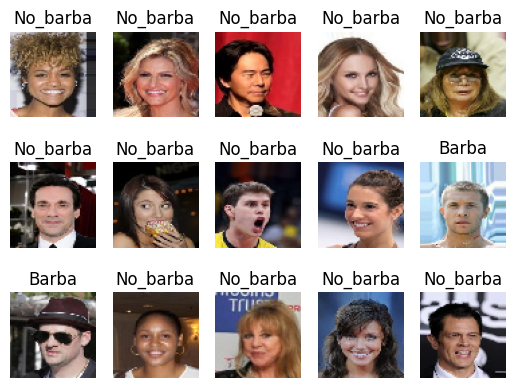

In [12]:
draw_images(train_generator, class_names)

# Machine Learning

A continuación, definimos y evaluamos diversas redes neuronales, comparando tanto el rendimiento como el desempeño del modelo. En primer lugar, definimos redes MPL (perceptrón multicapa) con diferentes parámetros; tales como cantidad de capas, neuronas, épocas, el tamaño del batch, el nivel de dropout.
Por consiguiente, agregamos una capa convolucional a la segunda red MPL, para luego definir otras CNN configurando parámetros como la cantidad de filtros, tamaño del kernel, cantidad de capas convolucionales.

## Funciones a utilizar en el entrenamiento

In [95]:
#Función para imprimir matriz de confusión

def ImprimirMatriz(modelo):
    datasets = (
        ('train',train_generator),
        ('validation',validation_generator),
    )

    for dataset_name, dataset in datasets:
        print('#' * 25, dataset_name, '#' * 25)

        batch_images, batch_labels = dataset.next()
        print('Samples:', len(batch_images))
    
        #predictions = modelo.predict(batch_images)
        #labels = batch_labels
        
        predictions = modelo.predict(batch_images)  # Aquí 'model' es tu modelo entrenado y 'X_test' son los datos de prueba
        predictions_binary = (predictions > 0.5).astype(int)  # Ajusta el umbral si es necesario
        labels = batch_labels  # Aquí 'y_test' son las etiquetas verdaderas de los datos de prueba

        # Calcula las métricas
        print('Accuracy:', accuracy_score(labels, predictions_binary))
        print('F1:', f1_score(labels, predictions_binary))
        print('Recall:', recall_score(labels, predictions_binary))
        print('Precision:', precision_score(labels, predictions_binary))
        
        
        #print(f'F1 por clase:')
        #print('----')
        #f1_score_per_class = f1_score(labels, predictions_binary, average=None)
        #for label, score in zip(class_names, f1_score_per_class):
        #    print(f'\t - F1 para la clase {label}: {score}')
        #    print('----')
        
        
        # graficamos la confussion matrix
        plt.figure(figsize=(4, 4))

        sns.heatmap(confusion_matrix(predictions_binary, labels), annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted value')
        plt.ylabel('True value')
        plt.title('Confusion Matrix')

        plt.show()
        
# Mostrar métricas a lo largo de las epocas
def MostrarHistorial(history):
    plt.plot(history.history['recall'], label='train_recall')
    plt.plot(history.history['val_recall'], label='validation_recall')
    plt.plot(history.history['precision'], label='train_precision')
    plt.plot(history.history['val_precision'], label='validation_precision')
    plt.title('Precision y Recall a lo largo de las epochs')
    plt.ylabel('Precision and Recall')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()
    
    
SIZE=64
input_shape=(SIZE,SIZE,3)

## Entrenamiento de modelos

## Modelo MPL 1

* Capas: 4 densas; una de 256, dos de 32 y una de 1 neurona.
* Función de activación: 'relu' en las primeras capas y 'sigmoid' en la salida.
* Cantidad de épocas: 10.
* Tamaño del batch: 100.

In [14]:
model_MPL_1 = Sequential(
    [
    Flatten(input_shape=input_shape),
    Dense(256,activation='relu'),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
]
)

model_MPL_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['Accuracy','Recall','Precision',])
model_MPL_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 12288)             0         
                                                                 
 dense (Dense)               (None, 256)               3145984   
                                                                 
 dense_1 (Dense)             (None, 32)                8224      
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,155,297
Trainable params: 3,155,297
Non-trainable params: 0
_________________________________________________________________


In [15]:
model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()
        
history_MPL_1 = model_MPL_1.fit(
    train_generator, validation_data = validation_generator, epochs=10, batch_size=BATCH_SIZE, verbose = 1, callbacks=[OurCustomCallback()]
)

Epoch 1/10
1628/1628 [==============================] - 106s 65ms/step - loss: 0.3147 - Accuracy: 0.8669 - recall: 0.9670 - precision: 0.8842 - val_loss: 0.2717 - val_Accuracy: 0.8841 - val_recall: 0.9874 - val_precision: 0.8850
Epoch 2/10
1628/1628 [==============================] - 101s 62ms/step - loss: 0.2561 - Accuracy: 0.8920 - recall: 0.9653 - precision: 0.9106 - val_loss: 0.2337 - val_Accuracy: 0.9037 - val_recall: 0.9695 - val_precision: 0.9180
Epoch 3/10
1628/1628 [==============================] - 101s 62ms/step - loss: 0.2405 - Accuracy: 0.8993 - recall: 0.9655 - precision: 0.9180 - val_loss: 0.2366 - val_Accuracy: 0.9045 - val_recall: 0.9778 - val_precision: 0.9123
Epoch 4/10
1628/1628 [==============================] - 100s 61ms/step - loss: 0.2341 - Accuracy: 0.9019 - recall: 0.9661 - precision: 0.9203 - val_loss: 0.2604 - val_Accuracy: 0.8877 - val_recall: 0.9086 - val_precision: 0.9526
Epoch 5/10
1628/1628 [==============================] - 101s 62ms/step - loss: 0.227

In [16]:
model_MPL_1.save("model_MPL_1.h5")

### Épocas y métricas

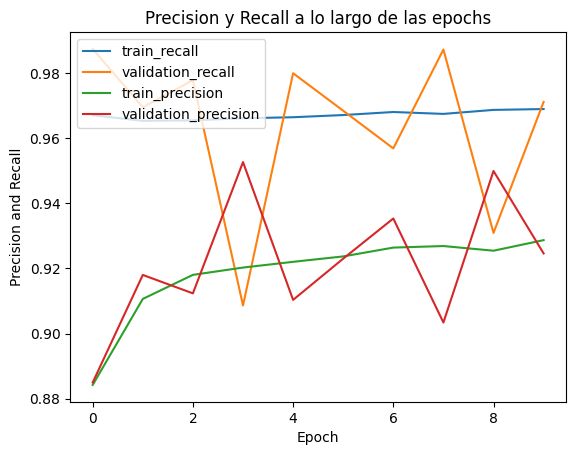

In [17]:
MostrarHistorial(history_MPL_1)

### Matriz de confusión

######################### train #########################
Samples: 100
4/4 [==============================] - 0s 5ms/step
Accuracy: 0.95
F1: 0.9685534591194969
Recall: 0.9746835443037974
Precision: 0.9625


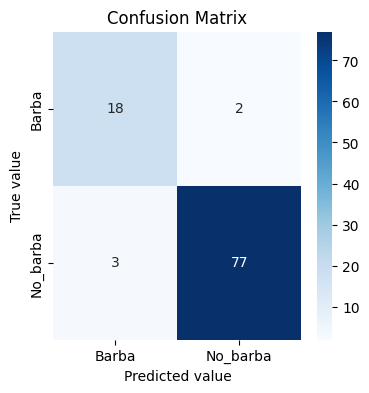

######################### validation #########################
Samples: 100
4/4 [==============================] - 0s 3ms/step
Accuracy: 0.85
F1: 0.9122807017543859
Recall: 0.975
Precision: 0.8571428571428571


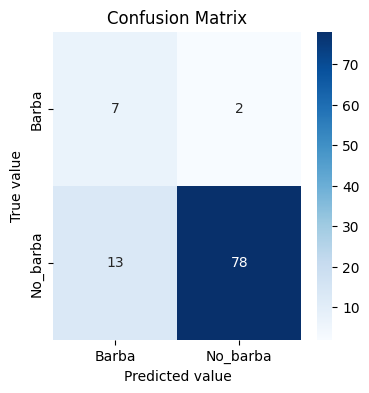

In [18]:
ImprimirMatriz(model_MPL_1)

La red MPL N.º 1 obtuvieron valores de F1 de 0.97 para el dataset de entrenamiento y de 0.91 para el dataset de validación en la última época, el entrenamiento duro en su totalidad 17 minutos aproximadamente. Por otra parte se obtuvo un valor elevado de loss de 0.21, lo que nos indica que el modelo no es eficiente al momento de predecir. Además, debido a la diferencia entre los valores de train y validation, también podemos interpretar que el modelo está sobreentrenado.

## Modelo MPL 2

* Capas: **8 densas; dos de 256, una de 64, dos de 50, dos de 32 y una de 1 neurona.**
* Función de activación: 'relu' en las primeras capas y 'sigmoid' en la salida.
* Cantidad de épocas: 10.
* Tamaño del batch: 100.

In [19]:
model_MPL_2 = Sequential(
    [
    Flatten(input_shape=input_shape),
    Dense(256,activation='relu'),
    Dense(256,activation='relu'),
    Dense(64,activation='relu'),
    Dense(50, activation='relu'),
    Dense(50,activation='relu'),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
]
)

model_MPL_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['Accuracy','Recall','Precision'])
model_MPL_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 12288)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               3145984   
                                                                 
 dense_5 (Dense)             (None, 256)               65792     
                                                                 
 dense_6 (Dense)             (None, 64)                16448     
                                                                 
 dense_7 (Dense)             (None, 50)                3250      
                                                                 
 dense_8 (Dense)             (None, 50)                2550      
                                                                 
 dense_9 (Dense)             (None, 32)               

In [20]:
model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()
        
history_MPL_2 = model_MPL_2.fit(
    train_generator, validation_data = validation_generator, epochs=10, batch_size=BATCH_SIZE, verbose = 1, callbacks=[OurCustomCallback()]
)

Epoch 1/10
1628/1628 [==============================] - 103s 62ms/step - loss: 0.3151 - Accuracy: 0.8667 - recall: 0.9666 - precision: 0.8844 - val_loss: 0.2537 - val_Accuracy: 0.8962 - val_recall: 0.9448 - val_precision: 0.9300
Epoch 2/10
1628/1628 [==============================] - 102s 63ms/step - loss: 0.2536 - Accuracy: 0.8937 - recall: 0.9663 - precision: 0.9116 - val_loss: 0.2429 - val_Accuracy: 0.9058 - val_recall: 0.9683 - val_precision: 0.9212
Epoch 3/10
1628/1628 [==============================] - 102s 63ms/step - loss: 0.2396 - Accuracy: 0.8996 - recall: 0.9674 - precision: 0.9168 - val_loss: 0.2338 - val_Accuracy: 0.9011 - val_recall: 0.9819 - val_precision: 0.9058
Epoch 4/10
1628/1628 [==============================] - 102s 63ms/step - loss: 0.2328 - Accuracy: 0.9027 - recall: 0.9685 - precision: 0.9192 - val_loss: 0.2218 - val_Accuracy: 0.9083 - val_recall: 0.9777 - val_precision: 0.9165
Epoch 5/10
1628/1628 [==============================] - 102s 63ms/step - loss: 0.224

### Épocas y métricas

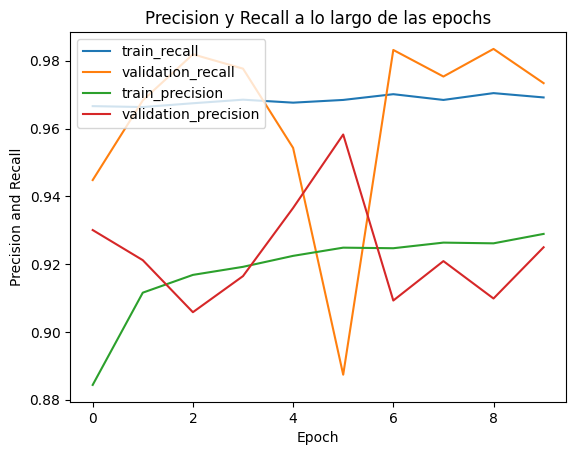

In [21]:
MostrarHistorial(history_MPL_2)

### Matriz de confusión

######################### train #########################
Samples: 100
4/4 [==============================] - 0s 4ms/step
Accuracy: 0.9
F1: 0.9411764705882354
Recall: 0.963855421686747
Precision: 0.9195402298850575


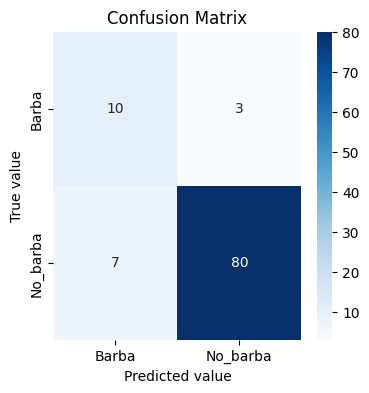

######################### validation #########################
Samples: 100
4/4 [==============================] - 0s 5ms/step
Accuracy: 0.89
F1: 0.9325153374233127
Recall: 0.95
Precision: 0.9156626506024096


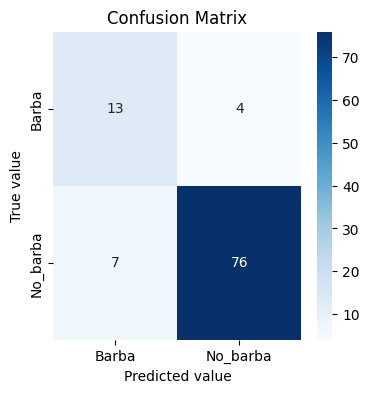

In [22]:
ImprimirMatriz(model_MPL_2)

La red MPL N.º 2 obtuvieron valores de F1 de 0.94 para el dataset de entrenamiento y de 0.93 para el dataset de validación en la última época, el entrenamiento duro en su totalidad 17 minutos aproximadamente. Por otra parte se obtuvo un valor elevado de loss de 0.21, lo que nos indica que el modelo no es eficiente al momento de predecir. A pesar de que el aumento en el número de capas ocultas puede conllevar al riesgo de que la red neuronal termine memorizando el conjunto de train, no se observa sobreentrenamiento, en este caso se mejoraron los valores de las métricas.

## Modelo MPL 3

* Capas: 8 densas; dos de 256, una de 64, dos de 50, dos de 32 y una de 1 neurona.
* Función de activación: 'relu' en las primeras capas y 'sigmoid' en la salida.
* Cantidad de épocas: 10.
* **Tamaño del batch: 40.**

In [87]:
model_MPL_3 = Sequential(
    [
    Flatten(input_shape=input_shape),
    Dense(256,activation='relu'),
    Dense(256,activation='relu'),
    Dense(64,activation='relu'),
    Dense(50, activation='relu'),
    Dense(50,activation='relu'),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
]
)

model_MPL_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','Recall','Precision',],
)
model_MPL_3.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_13 (Flatten)        (None, 12288)             0         
                                                                 
 dense_96 (Dense)            (None, 256)               3145984   
                                                                 
 dense_97 (Dense)            (None, 256)               65792     
                                                                 
 dense_98 (Dense)            (None, 64)                16448     
                                                                 
 dense_99 (Dense)            (None, 50)                3250      
                                                                 
 dense_100 (Dense)           (None, 50)                2550      
                                                                 
 dense_101 (Dense)           (None, 32)              

In [88]:
BATCH_SIZE=40

model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()
        
history_MPL_3 = model_MPL_3.fit(
    train_generator, validation_data = validation_generator, epochs=10, batch_size=BATCH_SIZE, verbose = 1, callbacks=[OurCustomCallback()]
)

Epoch 1/10
5087/5087 [==============================] - 165s 32ms/step - loss: 0.3031 - accuracy: 0.8722 - recall: 0.9693 - precision: 0.8878 - val_loss: 0.2717 - val_accuracy: 0.8795 - val_recall: 0.9914 - val_precision: 0.8779
Epoch 2/10
5087/5087 [==============================] - 161s 32ms/step - loss: 0.2500 - accuracy: 0.8954 - recall: 0.9663 - precision: 0.9133 - val_loss: 0.2294 - val_accuracy: 0.9060 - val_recall: 0.9788 - val_precision: 0.9132
Epoch 3/10
5087/5087 [==============================] - 160s 32ms/step - loss: 0.2392 - accuracy: 0.8996 - recall: 0.9672 - precision: 0.9170 - val_loss: 0.2248 - val_accuracy: 0.9071 - val_recall: 0.9712 - val_precision: 0.9202
Epoch 4/10
5087/5087 [==============================] - 161s 32ms/step - loss: 0.2315 - accuracy: 0.9025 - recall: 0.9693 - precision: 0.9184 - val_loss: 0.2164 - val_accuracy: 0.9106 - val_recall: 0.9710 - val_precision: 0.9241
Epoch 5/10
5087/5087 [==============================] - 161s 32ms/step - loss: 0.226

### Épocas y métricas

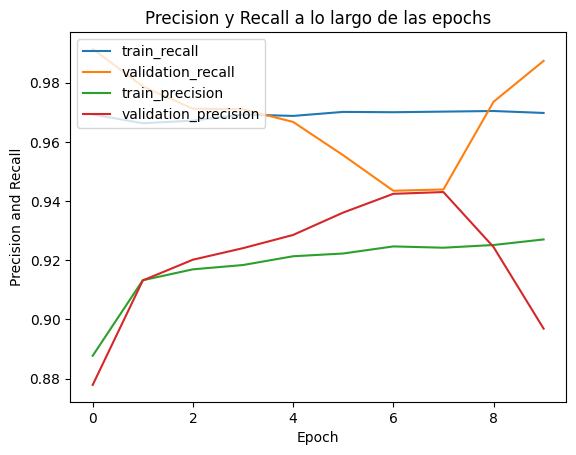

In [89]:
MostrarHistorial(history_MPL_3)

### Matriz de confusión

######################### train #########################
Samples: 32
1/1 [==============================] - 0s 72ms/step
Accuracy: 0.875
F1: 0.9310344827586207
Recall: 1.0
Precision: 0.8709677419354839


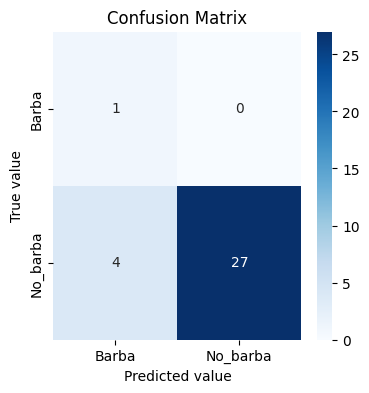

######################### validation #########################
Samples: 32
1/1 [==============================] - 0s 17ms/step
Accuracy: 0.8125
F1: 0.888888888888889
Recall: 1.0
Precision: 0.8


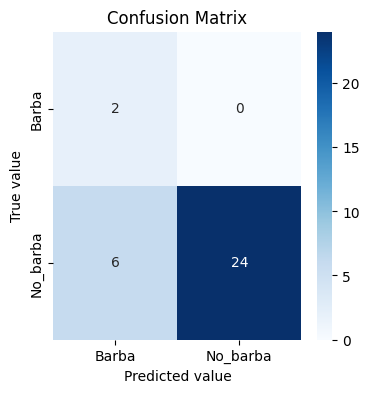

In [90]:
ImprimirMatriz(model_MPL_3)

La red MPL N.º 3 obtuvieron valores de F1 de 0.93 para el dataset de entrenamiento y de 0.88 para el dataset de validación en la última época, el entrenamiento duro en su totalidad 27 minutos aproximadamente. Por otra parte se obtuvo un valor elevado de loss de 0.2, lo que nos indica que el modelo no es eficiente al momento de predecir. Podemos observar que, con un tamaño de lote más pequeño que la red MPL N.º 2, el coste computacional incrementa y las métricas no parecen mejorar. Notamos que, en las matrices de confusión, el modelo parece predecir casi siempre que la persona no tiene barba, lo que nos puede indicar que no está obteniendo patrones sino que está prediciendo en base a la clase que mayor peso tiene.

## Modelo MPL 4

* Capas: 8 densas; dos de 256, una de 64, dos de 50, dos de 32 y una de 1 neurona.
* **Función de activación: 'tanh' en las primeras capas** y 'sigmoid' en la salida.
* Cantidad de épocas: 10.
* Tamaño del batch: 100.

In [27]:
model_MPL_4 = Sequential(
    [
    Flatten(input_shape=input_shape),
    Dense(256,activation='tanh'),
    Dense(256,activation='tanh'),
    Dense(64,activation='tanh'),
    Dense(50, activation='tanh'),
    Dense(50,activation='tanh'),
    Dense(32, activation='tanh'),
    Dense(32, activation='tanh'),
    Dense(1, activation='sigmoid')
]
)

model_MPL_4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','Recall','Precision',],)
model_MPL_4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 12288)             0         
                                                                 
 dense_20 (Dense)            (None, 256)               3145984   
                                                                 
 dense_21 (Dense)            (None, 256)               65792     
                                                                 
 dense_22 (Dense)            (None, 64)                16448     
                                                                 
 dense_23 (Dense)            (None, 50)                3250      
                                                                 
 dense_24 (Dense)            (None, 50)                2550      
                                                                 
 dense_25 (Dense)            (None, 32)               

In [28]:
BATCH_SIZE=100

model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()
        
history_MPL_4 = model_MPL_4.fit(
    train_generator, validation_data = validation_generator, epochs=10, batch_size=BATCH_SIZE, verbose = 1, callbacks=[OurCustomCallback()]
)

Epoch 1/10
1628/1628 [==============================] - 104s 63ms/step - loss: 0.4501 - accuracy: 0.8338 - recall: 0.9994 - precision: 0.8342 - val_loss: 0.4689 - val_accuracy: 0.8224 - val_recall: 1.0000 - val_precision: 0.8224
Epoch 2/10
1628/1628 [==============================] - 103s 63ms/step - loss: 0.4497 - accuracy: 0.8342 - recall: 1.0000 - precision: 0.8342 - val_loss: 0.4691 - val_accuracy: 0.8224 - val_recall: 1.0000 - val_precision: 0.8224
Epoch 3/10
1628/1628 [==============================] - 102s 63ms/step - loss: 0.4496 - accuracy: 0.8342 - recall: 1.0000 - precision: 0.8342 - val_loss: 0.4681 - val_accuracy: 0.8224 - val_recall: 1.0000 - val_precision: 0.8224
Epoch 4/10
1628/1628 [==============================] - 102s 63ms/step - loss: 0.4495 - accuracy: 0.8342 - recall: 1.0000 - precision: 0.8342 - val_loss: 0.4679 - val_accuracy: 0.8224 - val_recall: 1.0000 - val_precision: 0.8224
Epoch 5/10
1628/1628 [==============================] - 105s 64ms/step - loss: 0.449

### Épocas y métricas

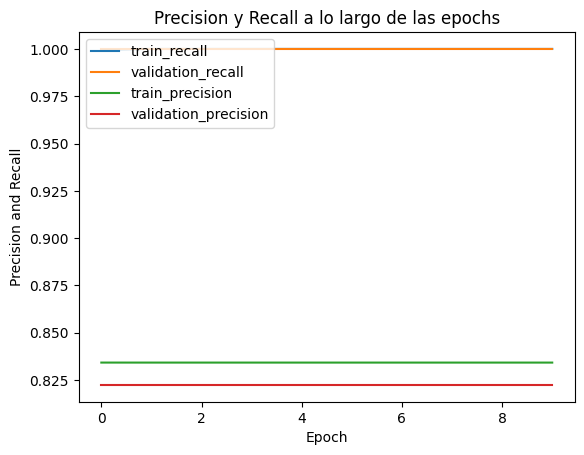

In [29]:
MostrarHistorial(history_MPL_4)

### Matriz de confusión

######################### train #########################
Samples: 100
4/4 [==============================] - 0s 7ms/step
Accuracy: 0.87
F1: 0.9304812834224598
Recall: 1.0
Precision: 0.87


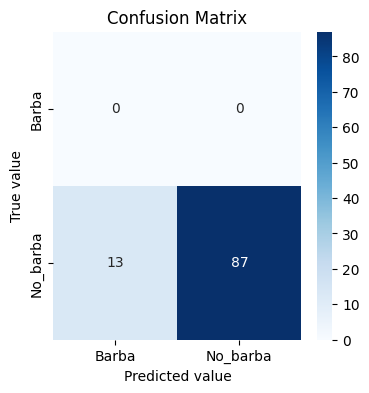

######################### validation #########################
Samples: 100
4/4 [==============================] - 0s 5ms/step
Accuracy: 0.87
F1: 0.9304812834224598
Recall: 1.0
Precision: 0.87


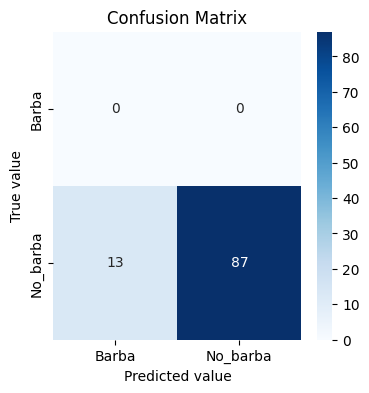

In [30]:
ImprimirMatriz(model_MPL_4)

La red MPL N.º 4 obtuvo un valor aproximado de F1 de 0.93 tanto para el dataset de entrenamiento como de validación en la última época, el entrenamiento duro en su totalidad 17 minutos aproximadamente. Por otra parte se obtuvo un valor elevado de loss de 0.45, lo que nos indica que el modelo no es eficiente al momento de predecir. Hubo un aumento del valor de loss debido al uso de la función de activación tanh, esto implica un deterioro en el rendimiento del modelo. Notamos que, en las matrices de confusión, el modelo parece predecir siempre que la persona no tiene barba, lo que nos puede indicar que no está obteniendo patrones sino que está prediciendo en base a la clase que mayor peso tiene.

## Modelo MPL 5

* Capas: 8 densas; dos de 256, una de 64, dos de 50, dos de 32 y una de 1 neurona.
* Función de activación: 'relu' en las primeras capas y 'sigmoid' en la salida.
* Cantidad de épocas: 10.
* Tamaño del batch: 100.
* **Se aplica un dropout del 30% para las capas ocultas.**

In [31]:
model_MPL_5 = Sequential(
    [
    Flatten(input_shape=input_shape),
    Dense(256,activation='relu'),
    Dropout(0.3),
    Dense(256,activation='relu'),
    Dropout(0.3),
    Dense(64,activation='relu'),
    Dropout(0.3),
    Dense(50, activation='relu'),
    Dropout(0.3),
    Dense(50,activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
]
)

model_MPL_5.compile( optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','Recall','Precision',],)
model_MPL_5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 12288)             0         
                                                                 
 dense_28 (Dense)            (None, 256)               3145984   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_29 (Dense)            (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_30 (Dense)            (None, 64)                16448     
                                                                 
 dropout_2 (Dropout)         (None, 64)               

In [32]:
model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()
        
history_MPL_5 = model_MPL_5.fit(
    train_generator, validation_data = validation_generator ,epochs=10, batch_size=BATCH_SIZE, verbose = 1, callbacks=[OurCustomCallback()]
)

Epoch 1/10
1628/1628 [==============================] - 104s 63ms/step - loss: 0.3883 - accuracy: 0.8332 - recall: 0.9986 - precision: 0.8342 - val_loss: 0.3996 - val_accuracy: 0.8224 - val_recall: 1.0000 - val_precision: 0.8224
Epoch 2/10
1628/1628 [==============================] - 102s 62ms/step - loss: 0.3347 - accuracy: 0.8342 - recall: 1.0000 - precision: 0.8342 - val_loss: 0.3639 - val_accuracy: 0.8224 - val_recall: 1.0000 - val_precision: 0.8224
Epoch 3/10
1628/1628 [==============================] - 105s 64ms/step - loss: 0.3126 - accuracy: 0.8422 - recall: 0.9620 - precision: 0.8642 - val_loss: 0.4102 - val_accuracy: 0.8852 - val_recall: 0.9631 - val_precision: 0.9036
Epoch 4/10
1628/1628 [==============================] - 103s 63ms/step - loss: 0.3017 - accuracy: 0.8592 - recall: 0.9165 - precision: 0.9148 - val_loss: 0.3877 - val_accuracy: 0.8789 - val_recall: 0.9155 - val_precision: 0.9359
Epoch 5/10
1628/1628 [==============================] - 105s 64ms/step - loss: 0.293

### Épocas y métricas

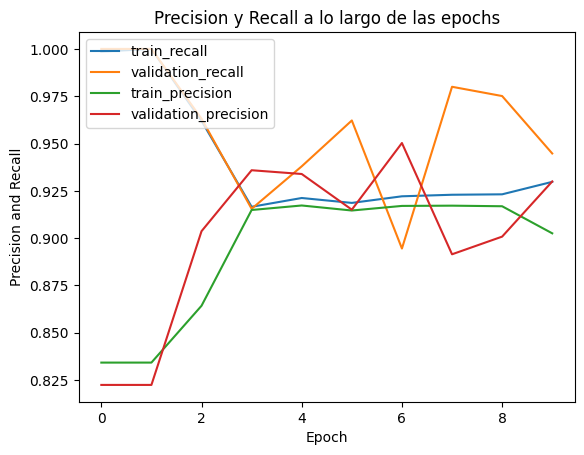

In [33]:
MostrarHistorial(history_MPL_5)

### Matriz de confusión

######################### train #########################
Samples: 100
4/4 [==============================] - 0s 8ms/step
Accuracy: 0.89
F1: 0.9325153374233129
Recall: 0.9743589743589743
Precision: 0.8941176470588236


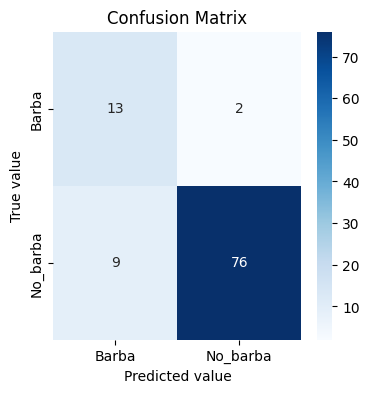

######################### validation #########################
Samples: 100
4/4 [==============================] - 0s 3ms/step
Accuracy: 0.92
F1: 0.9529411764705882
Recall: 0.9529411764705882
Precision: 0.9529411764705882


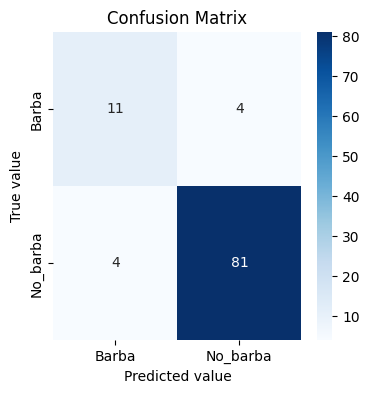

In [34]:
ImprimirMatriz(model_MPL_5)

La red MPL N.º 5 obtuvieron valores de F1 de 0.93 para el dataset de entrenamiento y de 0.95 para el dataset de validación en la última época, el entrenamiento duro en su totalidad aproximadamente 17 minutos. Por otra parte se obtuvo un valor elevado de loss de 0.3, lo que nos indica que el modelo no es eficiente al momento de predecir. Aplicando una capa de dropout que omite el 30% de las conexiones, se obtuvo un aumento en el valor de loss. No se observa sobreentrenamiento y los valores de las métricas obtenidas aumentaron respecto a los modelos anteriores.

## Modelo MPL 6

* Capas: 8 densas; dos de 256, una de 64, dos de 50, dos de 32 y una de 1 neurona.
* Función de activación: 'relu' en las primeras capas y 'sigmoid' en la salida.
* **Cantidad de épocas: 15.**
* Tamaño del batch: 100.

In [35]:
model_MPL_6 = Sequential(
    [
    Flatten(input_shape=input_shape),
    Dense(256,activation='relu'),
    Dense(256,activation='relu'),
    Dense(64,activation='relu'),
    Dense(50, activation='relu'),
    Dense(50,activation='relu'),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
]
)

model_MPL_6.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','Recall','Precision',],)
model_MPL_6.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 12288)             0         
                                                                 
 dense_36 (Dense)            (None, 256)               3145984   
                                                                 
 dense_37 (Dense)            (None, 256)               65792     
                                                                 
 dense_38 (Dense)            (None, 64)                16448     
                                                                 
 dense_39 (Dense)            (None, 50)                3250      
                                                                 
 dense_40 (Dense)            (None, 50)                2550      
                                                                 
 dense_41 (Dense)            (None, 32)               

In [36]:
model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()
        
history_MPL_6 = model_MPL_6.fit(
    train_generator, validation_data = validation_generator, epochs=15, batch_size=BATCH_SIZE, verbose = 1, callbacks=[OurCustomCallback()]
)

Epoch 1/15
1628/1628 [==============================] - 108s 65ms/step - loss: 0.3139 - accuracy: 0.8664 - recall: 0.9687 - precision: 0.8826 - val_loss: 0.2592 - val_accuracy: 0.8943 - val_recall: 0.9783 - val_precision: 0.9016
Epoch 2/15
1628/1628 [==============================] - 104s 64ms/step - loss: 0.2510 - accuracy: 0.8946 - recall: 0.9651 - precision: 0.9134 - val_loss: 0.2647 - val_accuracy: 0.8835 - val_recall: 0.9090 - val_precision: 0.9471
Epoch 3/15
1628/1628 [==============================] - 104s 64ms/step - loss: 0.2362 - accuracy: 0.9007 - recall: 0.9679 - precision: 0.9175 - val_loss: 0.3124 - val_accuracy: 0.8700 - val_recall: 0.9978 - val_precision: 0.8649
Epoch 4/15
1628/1628 [==============================] - 104s 64ms/step - loss: 0.2283 - accuracy: 0.9036 - recall: 0.9689 - precision: 0.9199 - val_loss: 0.2203 - val_accuracy: 0.9074 - val_recall: 0.9535 - val_precision: 0.9352
Epoch 5/15
1628/1628 [==============================] - 104s 64ms/step - loss: 0.224

### Épocas y métricas

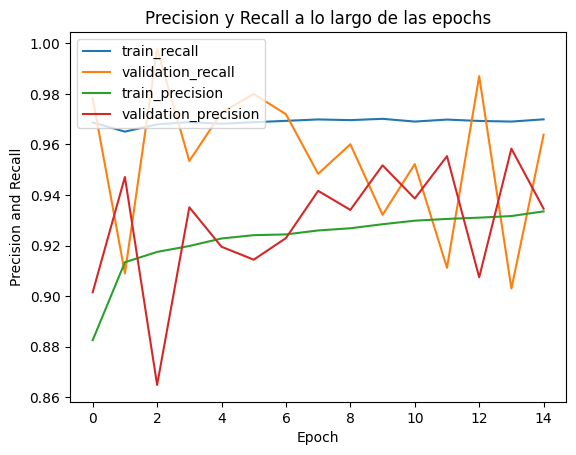

In [37]:
MostrarHistorial(history_MPL_6)

### Matriz de confusión 

######################### train #########################
Samples: 100
4/4 [==============================] - 0s 5ms/step
Accuracy: 0.93
F1: 0.9585798816568047
Recall: 0.9878048780487805
Precision: 0.9310344827586207


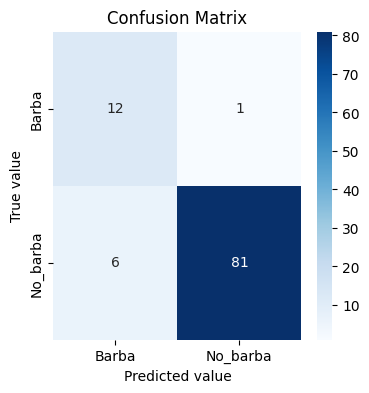

######################### validation #########################
Samples: 100
4/4 [==============================] - 0s 3ms/step
Accuracy: 0.91
F1: 0.9447852760736197
Recall: 0.9871794871794872
Precision: 0.9058823529411765


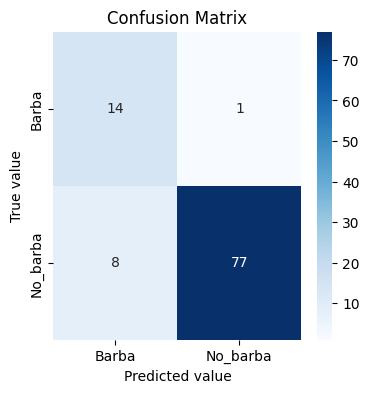

In [38]:
ImprimirMatriz(model_MPL_6)

La red MPL N.º 6 obtuvieron valores de F1 de 0.95 para el dataset de entrenamiento y de 0.94 para el dataset de validación en la última época, el entrenamiento duro en su totalidad aproximadamente 27 minutos. Por otra parte se obtuvo un valor elevado de loss de 0.2, lo que nos indica que el modelo no es eficiente al momento de predecir. No se observa sobreentrenamiento, las métricas mejoraron pero el valor de loss sigue siendo un problema.

## Modelo CVL 1

* Capas:
    * **1 convolucional con 8 filtros de 2x2 y stride 1.**
    * 8 densas; dos de 256, una de 64, dos de 50, dos de 32 y una de 1 neurona.
* **Max pooling de 4x4.**
* Función de activación: 'tanh' en las capas convolucionales, 'relu' en las capas densas y 'sigmoid' en la salida.
* Cantidad de épocas: 10.
* Tamaño del batch: 100.

In [46]:
model_CVL_1 = Sequential(
    [ 
    Convolution2D(filters=8, kernel_size=(2, 2), strides=1, activation='tanh',input_shape=input_shape),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(256,activation='relu'),
    Dense(256,activation='relu'),
    Dense(64,activation='relu'),
    Dense(50, activation='relu'),
    Dense(50,activation='relu'),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
]
)

model_CVL_1.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy','Recall','Precision',],)
model_CVL_1.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 63, 63, 8)         104       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 8)        0         
 2D)                                                             
                                                                 
 flatten_7 (Flatten)         (None, 7688)              0         
                                                                 
 dense_52 (Dense)            (None, 256)               1968384   
                                                                 
 dense_53 (Dense)            (None, 256)               65792     
                                                                 
 dense_54 (Dense)            (None, 64)                16448     
                                                      

In [47]:
model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()
        
history_CVL_1 = model_CVL_1.fit(
    train_generator, validation_data = validation_generator, epochs=10, batch_size=BATCH_SIZE, verbose = 1, callbacks=[OurCustomCallback()]
)

Epoch 1/10
1628/1628 [==============================] - 113s 69ms/step - loss: 0.2382 - accuracy: 0.8972 - recall: 0.9691 - precision: 0.9130 - val_loss: 0.1961 - val_accuracy: 0.9166 - val_recall: 0.9747 - val_precision: 0.9276
Epoch 2/10
1628/1628 [==============================] - 111s 68ms/step - loss: 0.1786 - accuracy: 0.9237 - recall: 0.9703 - precision: 0.9402 - val_loss: 0.1863 - val_accuracy: 0.9222 - val_recall: 0.9589 - val_precision: 0.9471
Epoch 3/10
1628/1628 [==============================] - 111s 68ms/step - loss: 0.1500 - accuracy: 0.9371 - recall: 0.9737 - precision: 0.9519 - val_loss: 0.1761 - val_accuracy: 0.9231 - val_recall: 0.9680 - val_precision: 0.9403
Epoch 4/10
1628/1628 [==============================] - 109s 67ms/step - loss: 0.1176 - accuracy: 0.9518 - recall: 0.9763 - precision: 0.9662 - val_loss: 0.2049 - val_accuracy: 0.9243 - val_recall: 0.9626 - val_precision: 0.9463
Epoch 5/10
1628/1628 [==============================] - 110s 67ms/step - loss: 0.084

### Épocas y métricas

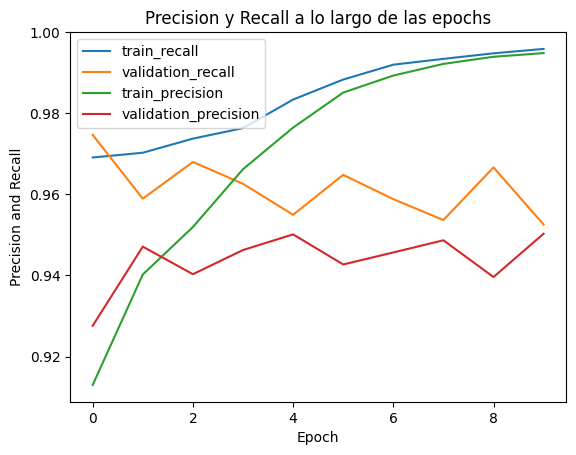

In [48]:
MostrarHistorial(history_CVL_1)

### Matriz de confusión

######################### train #########################
Samples: 100
4/4 [==============================] - 0s 7ms/step
Accuracy: 1.0
F1: 1.0
Recall: 1.0
Precision: 1.0


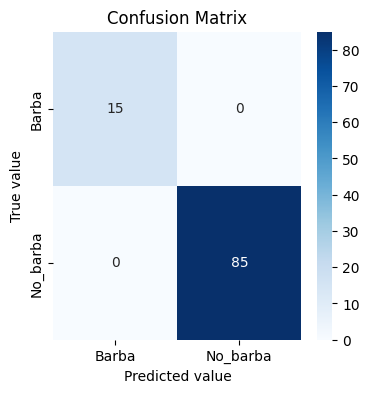

######################### validation #########################
Samples: 100
4/4 [==============================] - 0s 5ms/step
Accuracy: 0.92
F1: 0.949367088607595
Recall: 0.974025974025974
Precision: 0.9259259259259259


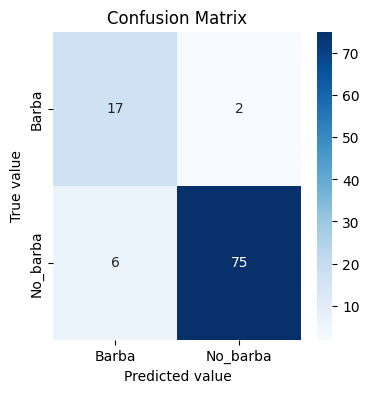

In [49]:
ImprimirMatriz(model_CVL_1)

La red CVL N.º 1 obtuvieron valores de F1 de 1 para el dataset de entrenamiento y de 0.94 para el dataset de validación en la última época, el entrenamiento duro en su totalidad 18 minutos aproximadamente. Por otra parte se obtuvo un valor de loss de 0.02, menor a los que obteniamos en los modelos MPL anteriores, lo que nos indica que el modelo es eficiente al momento de predecir. Sin embargo, el modelo claramente está sobreentrenando debido a que las métricas en el conjunto de entrenamiento tienen valor igual a 1.

## Modelo CVL 2

* Capas:
    * **4 convolucionales con 8 filtros de 2x2 y stride 1.**
    * 8 densas; dos de 256, una de 64, dos de 50, dos de 32 y una de 1 neurona.
* Max pooling de 4x4.
* Función de activación: 'tanh' en las capas convolucionales, 'relu' en las capas densas y 'sigmoid' en la salida.
* Cantidad de épocas: 10.
* Tamaño del batch: 100.

In [50]:
model_CVL_2 = Sequential(
    [ 
    Convolution2D(filters=8, kernel_size=(2, 2), strides=1, activation='tanh',input_shape=input_shape),
    Convolution2D(filters=8, kernel_size=(2, 2), strides=1, activation='tanh'),
    Convolution2D(filters=8, kernel_size=(2, 2), strides=1, activation='tanh'),
    Convolution2D(filters=8, kernel_size=(2, 2), strides=1, activation='tanh'),
    MaxPooling2D(pool_size=(4, 4)),
    Flatten(),
    Dense(256,activation='relu'),
    Dense(256,activation='relu'),
    Dense(64,activation='relu'),
    Dense(50, activation='relu'),
    Dense(50,activation='relu'),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
]
)

model_CVL_2.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy','Recall','Precision',],)
model_CVL_2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 63, 63, 8)         104       
                                                                 
 conv2d_3 (Conv2D)           (None, 62, 62, 8)         264       
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 8)         264       
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 8)         264       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 8)        0         
 2D)                                                             
                                                                 
 flatten_8 (Flatten)         (None, 1800)              0         
                                                      

In [51]:
model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()
        
history_CVL_2 = model_CVL_2.fit(
    train_generator, validation_data = validation_generator, epochs=10, batch_size=BATCH_SIZE, verbose = 1, callbacks=[OurCustomCallback()]
)

Epoch 1/10
1628/1628 [==============================] - 218s 133ms/step - loss: 0.2405 - accuracy: 0.8960 - recall: 0.9689 - precision: 0.9119 - val_loss: 0.1858 - val_accuracy: 0.9223 - val_recall: 0.9633 - val_precision: 0.9435
Epoch 2/10
1628/1628 [==============================] - 216s 133ms/step - loss: 0.1758 - accuracy: 0.9253 - recall: 0.9701 - precision: 0.9420 - val_loss: 0.1744 - val_accuracy: 0.9258 - val_recall: 0.9624 - val_precision: 0.9481
Epoch 3/10
1628/1628 [==============================] - 215s 132ms/step - loss: 0.1575 - accuracy: 0.9336 - recall: 0.9715 - precision: 0.9500 - val_loss: 0.1653 - val_accuracy: 0.9303 - val_recall: 0.9658 - val_precision: 0.9502
Epoch 4/10
1628/1628 [==============================] - 217s 133ms/step - loss: 0.1424 - accuracy: 0.9401 - recall: 0.9727 - precision: 0.9562 - val_loss: 0.1628 - val_accuracy: 0.9317 - val_recall: 0.9746 - val_precision: 0.9442
Epoch 5/10
1628/1628 [==============================] - 217s 133ms/step - loss: 

In [52]:
model_CVL_2.save("model_CVL_2.h5")

### Épocas y métricas

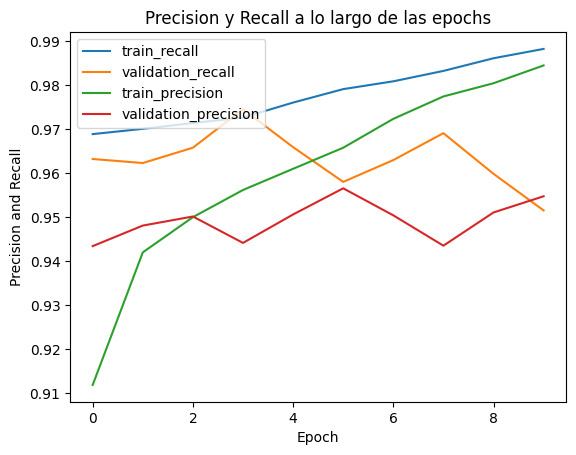

In [55]:
MostrarHistorial(history_CVL_2)

### Matriz de confusión

######################### train #########################
Samples: 100
4/4 [==============================] - 0s 9ms/step
Accuracy: 0.99
F1: 0.993939393939394
Recall: 0.9879518072289156
Precision: 1.0


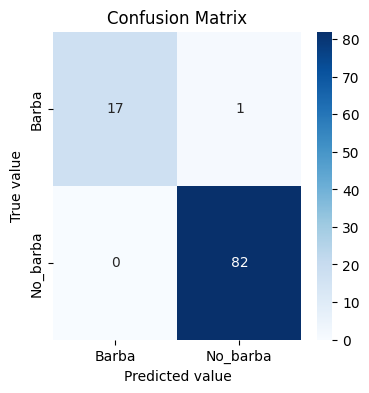

######################### validation #########################
Samples: 100
4/4 [==============================] - 0s 9ms/step
Accuracy: 0.91
F1: 0.9419354838709677
Recall: 0.9240506329113924
Precision: 0.9605263157894737


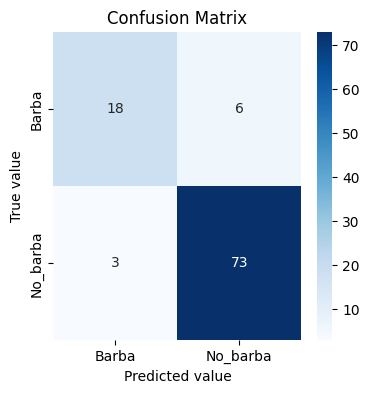

In [54]:
ImprimirMatriz(model_CVL_2)

La red CVL N.º 2 obtuvieron valores de F1 de 0.99 para el dataset de entrenamiento y de 0.94 para el dataset de validación en la última época, el entrenamiento duro en su totalidad 37 minutos aproximadamente. Por otra parte se obtuvo un valor de loss de 0.05, menor a los que obteniamos en los modelos MPL anteriores, lo que nos indica que el modelo es eficiente al momento de predecir. Sin embargo, el modelo claramente está sobreentrenando debido a que las métricas en el conjunto de entrenamiento tienen valor (casi) igual a 1.

## Modelo CVL 3

* Capas:
    * 2 convolucionales con 8 filtros de 2x2 y stride 1.
    * **2 convolucionales con 16 filtros de 4x4 y stride 1.**
    * 8 densas; dos de 256, una de 64, dos de 50, dos de 32 y una de 1 neurona.
* Max pooling de 4x4.
* Función de activación: 'tanh' en las capas convolucionales, 'relu' en las capas densas y 'sigmoid' en la salida.
* Cantidad de épocas: 10.
* Tamaño del batch: 100.

In [56]:
model_CVL_3 = Sequential(
    [ 
    Convolution2D(filters=8, kernel_size=(2, 2), strides=1, activation='tanh',input_shape=input_shape),
    Convolution2D(filters=8, kernel_size=(2, 2), strides=1, activation='relu'),
    Convolution2D(filters=16, kernel_size=(4, 4), strides=1, activation='tanh'),
    Convolution2D(filters=16, kernel_size=(4, 4), strides=1, activation='relu'),
    MaxPooling2D(pool_size=(4, 4)),
    Flatten(),
    Dense(256,activation='relu'),
    Dense(256,activation='relu'),
    Dense(64,activation='relu'),
    Dense(50, activation='relu'),
    Dense(50,activation='relu'),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
]
)

model_CVL_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','Recall','Precision',],
)
model_CVL_3.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 63, 63, 8)         104       
                                                                 
 conv2d_7 (Conv2D)           (None, 62, 62, 8)         264       
                                                                 
 conv2d_8 (Conv2D)           (None, 59, 59, 16)        2064      
                                                                 
 conv2d_9 (Conv2D)           (None, 56, 56, 16)        4112      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 flatten_9 (Flatten)         (None, 3136)              0         
                                                      

In [57]:
model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()
        
history_CVL_3 = model_CVL_3.fit(
    train_generator, validation_data = validation_generator, epochs=10, batch_size=BATCH_SIZE, verbose = 1, callbacks=[OurCustomCallback()]
)

Epoch 1/10
1628/1628 [==============================] - 430s 263ms/step - loss: 0.2155 - accuracy: 0.9099 - recall: 0.9711 - precision: 0.9247 - val_loss: 0.1695 - val_accuracy: 0.9297 - val_recall: 0.9865 - val_precision: 0.9320
Epoch 2/10
1628/1628 [==============================] - 429s 263ms/step - loss: 0.1556 - accuracy: 0.9361 - recall: 0.9740 - precision: 0.9506 - val_loss: 0.1439 - val_accuracy: 0.9398 - val_recall: 0.9723 - val_precision: 0.9553
Epoch 3/10
1628/1628 [==============================] - 429s 264ms/step - loss: 0.1399 - accuracy: 0.9424 - recall: 0.9741 - precision: 0.9576 - val_loss: 0.1354 - val_accuracy: 0.9448 - val_recall: 0.9763 - val_precision: 0.9574
Epoch 4/10
1628/1628 [==============================] - 429s 263ms/step - loss: 0.1290 - accuracy: 0.9475 - recall: 0.9764 - precision: 0.9613 - val_loss: 0.1459 - val_accuracy: 0.9424 - val_recall: 0.9830 - val_precision: 0.9487
Epoch 5/10
1628/1628 [==============================] - 429s 263ms/step - loss: 

### Épocas y métricas

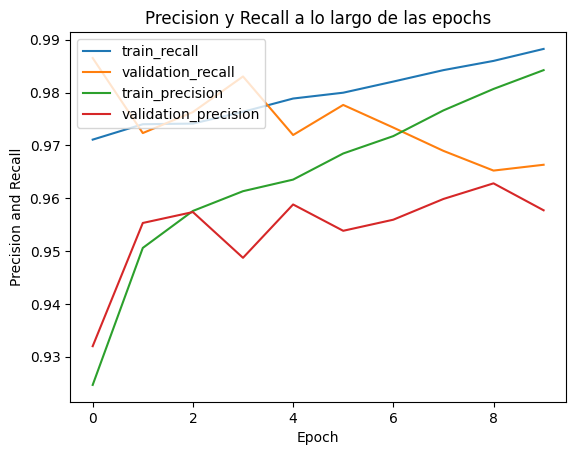

In [60]:
MostrarHistorial(history_CVL_3)

### Graficar matriz de confusión

######################### train #########################
Samples: 100
4/4 [==============================] - 0s 12ms/step
Accuracy: 0.98
F1: 0.9880952380952381
Recall: 0.9880952380952381
Precision: 0.9880952380952381


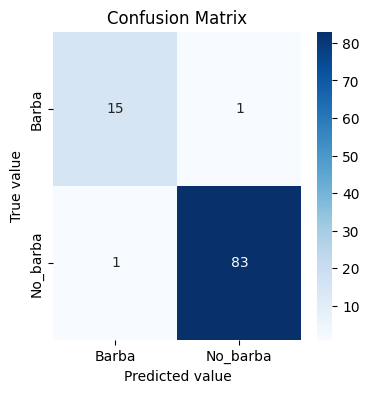

######################### validation #########################
Samples: 100
4/4 [==============================] - 0s 12ms/step
Accuracy: 0.95
F1: 0.9707602339181286
Recall: 0.9651162790697675
Precision: 0.9764705882352941


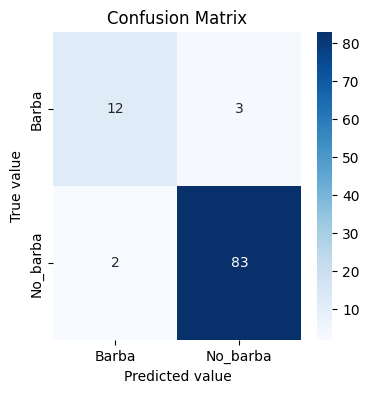

In [59]:
ImprimirMatriz(model_CVL_3)

La red CVL N.º 3 obtuvieron valores de F1 de 0.99 para el dataset de entrenamiento y de 0.97 para el dataset de validación en la última época, el entrenamiento duro en su totalidad 1 hora con 12 minutos aproximadamente. Por otra parte se obtuvo un valor de loss de 0.05, menor a los que obteniamos en los modelos MPL anteriores, lo que nos indica que el modelo es eficiente al momento de predecir. Sin embargo, el modelo claramente está sobreentrenando debido a que las métricas en el conjunto de entrenamiento tienen valor (casi) igual a 1.

## Transfer Learning

A continuación aplicamos Transfer Learning al modelo pre-entrenado VGG16, adaptando la estrucutra de las últimas capas y re-entrenandolas.

In [96]:
pretrained_model = VGG16(include_top=False, input_shape= IMAGE_SIZE + (3,))
pretrained_model.trainable = False

vgg16_model = Sequential(
    [
    pretrained_model,
    Flatten(),
    Dense(256,activation='relu'),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
]
)

# Compile the model
vgg16_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','Recall','Precision',],)
vgg16_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_14 (Flatten)        (None, 2048)              0         
                                                                 
 dense_104 (Dense)           (None, 256)               524544    
                                                                 
 dense_105 (Dense)           (None, 32)                8224      
                                                                 
 dense_106 (Dense)           (None, 32)                1056      
                                                                 
 dense_107 (Dense)           (None, 1)                 33        
                                                                 
Total params: 15,248,545
Trainable params: 533,857
No

In [97]:
model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()
        
history_vgg16 = vgg16_model.fit(
    train_generator, validation_data = validation_generator, epochs=5, batch_size=BATCH_SIZE, verbose = 1, callbacks=[OurCustomCallback()]
)

Epoch 1/5
5087/5087 [==============================] - 1319s 259ms/step - loss: 0.3274 - accuracy: 0.8478 - recall: 0.9673 - precision: 0.8659 - val_loss: 0.3189 - val_accuracy: 0.8526 - val_recall: 0.9581 - val_precision: 0.8747
Epoch 2/5
5087/5087 [==============================] - 1344s 264ms/step - loss: 0.3089 - accuracy: 0.8561 - recall: 0.9642 - precision: 0.8758 - val_loss: 0.3348 - val_accuracy: 0.8392 - val_recall: 0.9947 - val_precision: 0.8395
Epoch 3/5
5087/5087 [==============================] - 1339s 263ms/step - loss: 0.3005 - accuracy: 0.8598 - recall: 0.9616 - precision: 0.8812 - val_loss: 0.3120 - val_accuracy: 0.8548 - val_recall: 0.9710 - val_precision: 0.8681
Epoch 4/5
5087/5087 [==============================] - 1356s 266ms/step - loss: 0.2941 - accuracy: 0.8630 - recall: 0.9635 - precision: 0.8829 - val_loss: 0.3123 - val_accuracy: 0.8537 - val_recall: 0.9751 - val_precision: 0.8644
Epoch 5/5
5087/5087 [==============================] - 1351s 266ms/step - loss: 

### Épocas y métricas

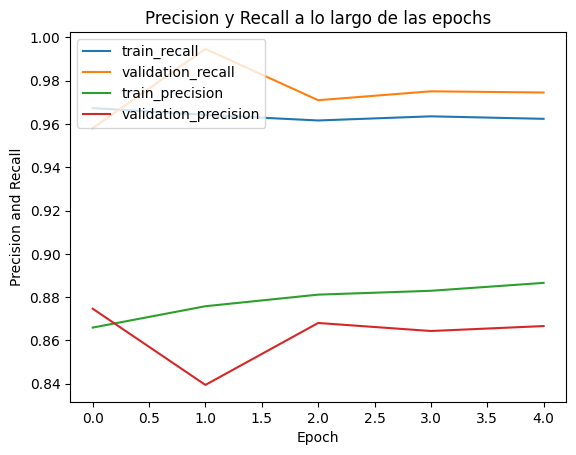

In [98]:
MostrarHistorial(history_vgg16)

### Matriz de confusión

######################### train #########################
Samples: 32
1/1 [==============================] - 0s 306ms/step
Accuracy: 0.71875
F1: 0.823529411764706
Recall: 0.9545454545454546
Precision: 0.7241379310344828


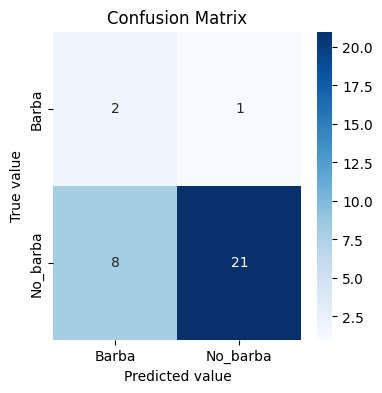

######################### validation #########################
Samples: 32
1/1 [==============================] - 0s 203ms/step
Accuracy: 0.875
F1: 0.9310344827586207
Recall: 0.9642857142857143
Precision: 0.9


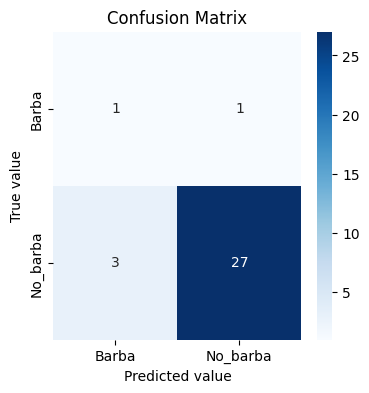

In [99]:
ImprimirMatriz(vgg16_model)

En este modelo se obtuvieron valores de F1 de 0.82 para el dataset de entrenamiento y de 0.93 para el dataset de validación en la última época, el entrenamiento duro en su totalidad 1 hora y 40 minutos aproximadamente. Por otra parte se obtuvo un valor elevado de loss de 0.28, lo que nos indica que el modelo no es eficiente al momento de predecir. Comparando con el MPL N.º 1, el valor de loss y el tiempo de entrenamiento aumentó pero la métrica F1 (obtenida en el dataset de validación) mejoró en este nuevo modelo.

## Aplicación de técnica de ampliación de datos

A continuación se genera un nuevo conjunto de imagenes modificando las imagenes del dataset train, para posteriormente usar el conjunto de datos nuevos para entrenar el modelo MPL N.º 1.

In [61]:
datagen_extra = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=(0.5, 1.5),
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.1,
)

parameters = dict(
    x_col='image_id',
    y_col='No_Beard',
    target_size=(IMAGE_SIZE),
    class_mode='binary',
)

train_generator_extra = datagen_extra.flow_from_dataframe(train, str(imgs_path) + "/",**parameters)

Found 162770 validated image filenames belonging to 2 classes.


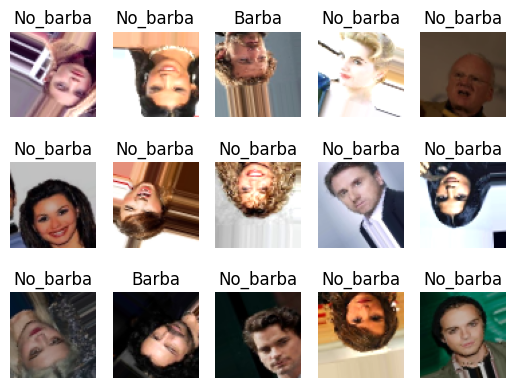

In [62]:
# Dibujar imagenes modificadas de ejemplo
def draw_images(dataset, class_names):
    cant_imgs = 15
    row_plt = 3
    col_plt = 5
    images, labels = dataset.next()
    for i in range(cant_imgs):
        ax = plt.subplot(row_plt, col_plt, i + 1)
        plt.imshow(images[i])
        class_index = "No_barba" if labels[i] == 1 else "Barba"
        plt.title(class_index)
        plt.grid(False)
        plt.axis("off")
        
draw_images(train_generator_extra, class_names)

In [63]:
model_MPL_e = Sequential(
    [
    Flatten(input_shape=input_shape),
    Dense(256,activation='relu'),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
]
)

model_MPL_e.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','Recall','Precision',])
model_MPL_e.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_10 (Flatten)        (None, 12288)             0         
                                                                 
 dense_76 (Dense)            (None, 256)               3145984   
                                                                 
 dense_77 (Dense)            (None, 32)                8224      
                                                                 
 dense_78 (Dense)            (None, 32)                1056      
                                                                 
 dense_79 (Dense)            (None, 1)                 33        
                                                                 
Total params: 3,155,297
Trainable params: 3,155,297
Non-trainable params: 0
_________________________________________________________________


In [64]:
model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()
        
history_MPL_e = model_MPL_e.fit(
    train_generator_extra, validation_data = validation_generator, epochs=10, batch_size=BATCH_SIZE, verbose = 1, callbacks=[OurCustomCallback()]
)

Epoch 1/10
5087/5087 [==============================] - 315s 62ms/step - loss: 0.4494 - accuracy: 0.8338 - recall: 0.9993 - precision: 0.8342 - val_loss: 0.4478 - val_accuracy: 0.8224 - val_recall: 1.0000 - val_precision: 0.8224
Epoch 2/10
5087/5087 [==============================] - 307s 60ms/step - loss: 0.4379 - accuracy: 0.8342 - recall: 1.0000 - precision: 0.8342 - val_loss: 0.4453 - val_accuracy: 0.8224 - val_recall: 1.0000 - val_precision: 0.8224
Epoch 3/10
5087/5087 [==============================] - 308s 61ms/step - loss: 0.4357 - accuracy: 0.8342 - recall: 1.0000 - precision: 0.8342 - val_loss: 0.4382 - val_accuracy: 0.8224 - val_recall: 1.0000 - val_precision: 0.8224
Epoch 4/10
5087/5087 [==============================] - 309s 61ms/step - loss: 0.4338 - accuracy: 0.8342 - recall: 1.0000 - precision: 0.8342 - val_loss: 0.4422 - val_accuracy: 0.8224 - val_recall: 1.0000 - val_precision: 0.8224
Epoch 5/10
5087/5087 [==============================] - 308s 60ms/step - loss: 0.432

In [65]:
model_MPL_e.save("model_MPL_e.h5")

### Épocas y métricas

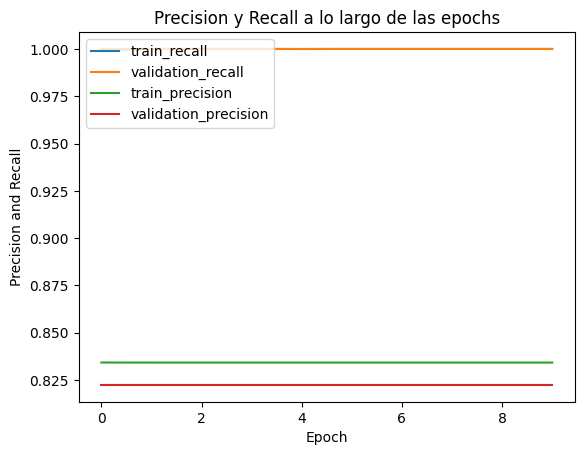

In [66]:
MostrarHistorial(history_MPL_e)

### Matriz de confusión

######################### train #########################
Samples: 100
4/4 [==============================] - 0s 3ms/step
Accuracy: 0.82
F1: 0.9010989010989011
Recall: 1.0
Precision: 0.82


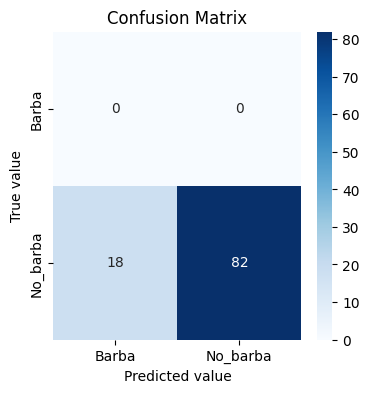

######################### validation #########################
Samples: 100
4/4 [==============================] - 0s 4ms/step
Accuracy: 0.84
F1: 0.9130434782608696
Recall: 1.0
Precision: 0.84


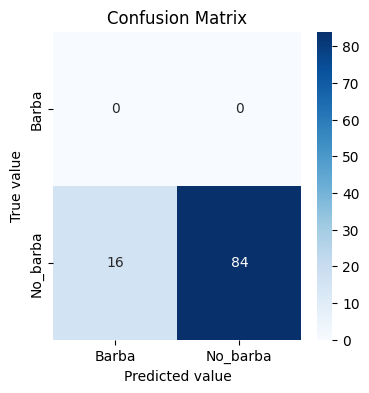

In [67]:
ImprimirMatriz(model_MPL_e)

En este modelo se obtuvieron valores de F1 de 0.9 para el dataset de entrenamiento y de 0.91 para el dataset de validación en la última época, el entrenamiento duro en su totalidad 52 minutos aproximadamente. Por otra parte se obtuvo un valor elevado de loss de 0.43, lo que nos indica que el modelo no es eficiente al momento de predecir. Notamos que, en las matrices de confusión, el modelo parece predecir siempre que la persona no tiene barba, lo que nos puede indicar que no está obteniendo patrones sino que está prediciendo en base a la clase que mayor peso tiene. Comparando con el MPL N.º 1, el valor de loss y el tiempo de entrenamiento aumentó, la métrica F1 (obtenida en el dataset de validación) no mejoró.

En nuestro caso, la técnica no aportó mejoras, suponemos que se debe a que las alteraciones sobre las imágenes no fueron adecuadas para el modelo.

# Conclusiones

Considerando los resultados vistos a lo largo del trabajo, los modelos en general se confunden al detectar si una persona tiene barba. Esto se debe a que es una clase con menor peso que su contraparte "no_barba", una solución a esto es balancear los datos (ya sea dando un mayor peso a los valores menos preponderantes o reduciendo el dataset, quitando imágenes con personas sin barba.

Los valores de las métricas y de loss para las redes convolucionales presentan mejoras respecto a las redes MPL, esto se debe a que su funcionamiento y la información espacial compartida entre neuronas les permite reconocer automáticamente features particulares. No obstante, notamos que se encuentran sobreentrenadas, una solución a esto sería plantear modelos con una cantidad menor de capas densas y distintas configuraciones. Además, los tiempos de entrenamiento resultaron mayores debido a la gran cantidad 

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from IPython.display import Image, display

def show_and_predict(image_path):
    image_array = img_to_array(load_img(image_path, target_size=(64, 64)))
    inputs = np.array([image_array])  # armamos un "dataset" con solo esa imagen
    predictions = model_MPL_1.predict(inputs)
    display(Image(image_path, width=100))
    predicted_classes = ["Barba" if p < 0.5 else "No_Barba" for p in predictions]
    print("Prediction:", predicted_classes)
    print("Prediction detail:", predictions)

show_and_predict("C:/Users/matia/OneDrive/Documentos/archive/img_align_celeba/img_align_celeba/197454.jpg"
                 
show_and_predict("C:/Users/matia/OneDrive/Documentos/archive/img_align_celeba/img_align_celeba/197454.jpg") #barba
show_and_predict("C:/Users/matia/OneDrive/Documentos/archive/img_align_celeba/img_align_celeba/197480.jpg") #barba
show_and_predict("C:/Users/matia/OneDrive/Documentos/archive/img_align_celeba/img_align_celeba/197481.jpg") #barba